In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

vocab_size = len(stoi)

In [4]:
block_size = 3

In [5]:
def form_dataset(words):
    X = []
    Y = []

    for word in words:
        word = ['.'] * block_size + list(word) + ['.']
        for ind in range(3, len(word)):
            X.append([stoi[x] for x in word[ind-3:ind]])
            Y.append(stoi[word[ind]])
            # print(''.join(word[ind-3:ind]), '--->', word[ind])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Form dataset
Divide into 3: usual splits are 80, 10, 10

In [6]:
import random
random.seed(42)
random.shuffle(names)

X, Y = form_dataset(names)

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0) # input is split into X[:n1], X[n1:n2] and X[n2:]
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
print(Ytr.shape, Ydev.shape, Yts.shape)

torch.Size([182516]) torch.Size([22815]) torch.Size([22815])


In [71]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g) / (in_features ** 0.5) # Glorot initialization
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        # forward pass        
        self.out = x @ self.weight
        if self.bias is not None:
            self.out = self.out + self.bias
        
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        """
        dim: Dimensionality or num_features
        """
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.training = True # By default for training

        self.gamma = torch.ones(dim) # initialized to 1 for multiplication
        self.beta = torch.zeros(dim) # initialized to 0 for addition

        # track running stats is True by default
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xstd = x.std(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xstd = self.running_variance

        xhat = (x - xmean) / torch.sqrt(xstd + self.eps)
        self.out =  self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad(): # context manager
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_variance = self.momentum * xstd + (1-self.momentum) * self.running_variance
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.rand(num_embeddings, embedding_dim)
    
    def __call__(self, X):
        return self.weight[X]
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, X):
        return X.view(X.shape[0], -1)
    
    def parameters(self):
        return []

In [47]:
Embedding(27, 10).parameters()[0].nelement()

270

In [72]:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

# C = Embedding(vocab_size, n_embd) # embedding matrix used to encode the dataset into vector space of 10

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
	Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
	Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
	Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
	Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
	Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
	Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
	layers[-1].gamma *= 0.1

parameters = [p for layer in layers for p in layer.parameters()]
count = sum(p.nelement() for p in parameters)
print('Total parameters:', count)
for p in parameters:
	p.requires_grad = True

lossi = []

Total parameters: 47551


In [74]:
max_steps = 10
print_step_size = 1000
batch_size = 32
ud = []

for step in range(max_steps):
    # mini batch construction
    batch_inds = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[batch_inds], Ytr[batch_inds]
    
    x = Xb
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    # print(loss.item())
    if step%print_step_size == 0:
        print(f'{step}/{max_steps}:', loss.item())

    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()
    lossi.append(loss.log10().item())
    
    lr = 0.1 if step < 150000 else 0.01 # step learning rate decay
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    for p in parameters:
        p.data += -lr * p.grad
    
print(loss.item())

0/10: 3.2297298908233643
3.1939480304718018


torch.Size([200])


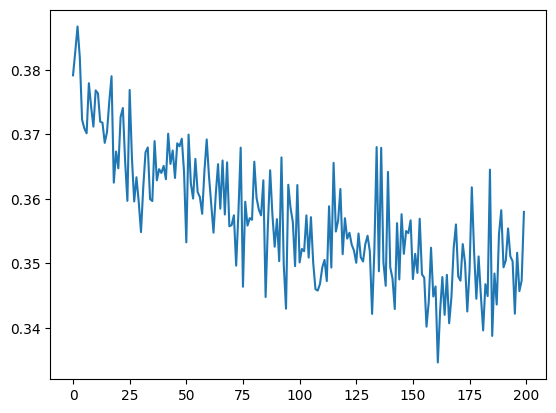

In [36]:
print(torch.tensor(lossi).view(200, -1).mean(1).shape)
plt.plot(torch.tensor(lossi).view(200, -1).mean(1))